In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

from NIDS_attacks.fgsm import attack_fgsm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    log_dir=f"{root_dir}/results/logs",
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-24 18:30:50,900 - INFO - Logger initialized for 'TDM_20251124_183050'
2025-11-24 18:30:50,901 - INFO - Using device: cuda:0


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label")

2025-11-24 18:30:50,908 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-24 18:30:51,475 - INFO - Loading dataset into DataFrame
2025-11-24 18:31:04,691 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-24 18:31:19,934 - INFO - ============================================================
2025-11-24 18:31:19,935 - INFO - Preprocessing completed successfully
2025-11-24 18:31:19,936 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-24 18:31:19,936 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-24 18:31:19,937 - INFO - data retention rate: 87.64%
2025-11-24 18:31:19,937 - INFO - ============================================================
2025-11-24 18:31:19,938 - INFO - Optimizing memory usage of the dataset...
2025-11-24 18:31:19,942 - INFO - Initial memory usage: 1066.05 MB
2025-11-24 18:31:20,680 - INFO - Optimized memory usage: 555.24 MB
2025-11-24 18:31:20,680 - INFO - Memory reduction: 510.82 MB (47.92%)
20

In [3]:
dataset = full_dataset.subset(size=900*1000, multi_class=True)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-24 18:31:21,495 - INFO - Subsetting dataset to size: 900000...
2025-11-24 18:31:21,506 - INFO - Class distribution before subsetting:
2025-11-24 18:31:21,507 - INFO -   Class 0: 1528113 samples
2025-11-24 18:31:21,507 - INFO -   Class 1: 128016 samples
2025-11-24 18:31:21,508 - INFO -   Class 2: 193745 samples
2025-11-24 18:31:21,509 - INFO -   Class 3: 90819 samples
2025-11-24 18:31:21,589 - INFO - Subsetted dataset to size: 637580
2025-11-24 18:31:22,090 - INFO - Splitting dataset into training and testing sets...
2025-11-24 18:31:25,348 - INFO - Class distribution before SMOTE:
2025-11-24 18:31:25,349 - INFO -   Class 0.0: 179897 samples
2025-11-24 18:31:25,350 - INFO -   Class 1.0: 102427 samples
2025-11-24 18:31:25,350 - INFO -   Class 2.0: 155243 samples
2025-11-24 18:31:25,351 - INFO -   Class 3.0: 72497 samples
2025-11-24 18:31:25,354 - INFO - Class distribution after SMOTE:
2025-11-24 18:31:25,354 - INFO -   Class 0.0: 179897 samples
2025-11-24 18:31:25,355 - INFO -   

In [4]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(
    input_size=input_size,
    num_classes=num_classes,
    device=device
)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pytorch_attack/MLP{input_size}x{num_classes}.400.pt")

Input Size: 70, Num Classes: 4


2025-11-24 18:31:25,598 - INFO - Running analysis for PyTorch model: Model on device: cuda:0


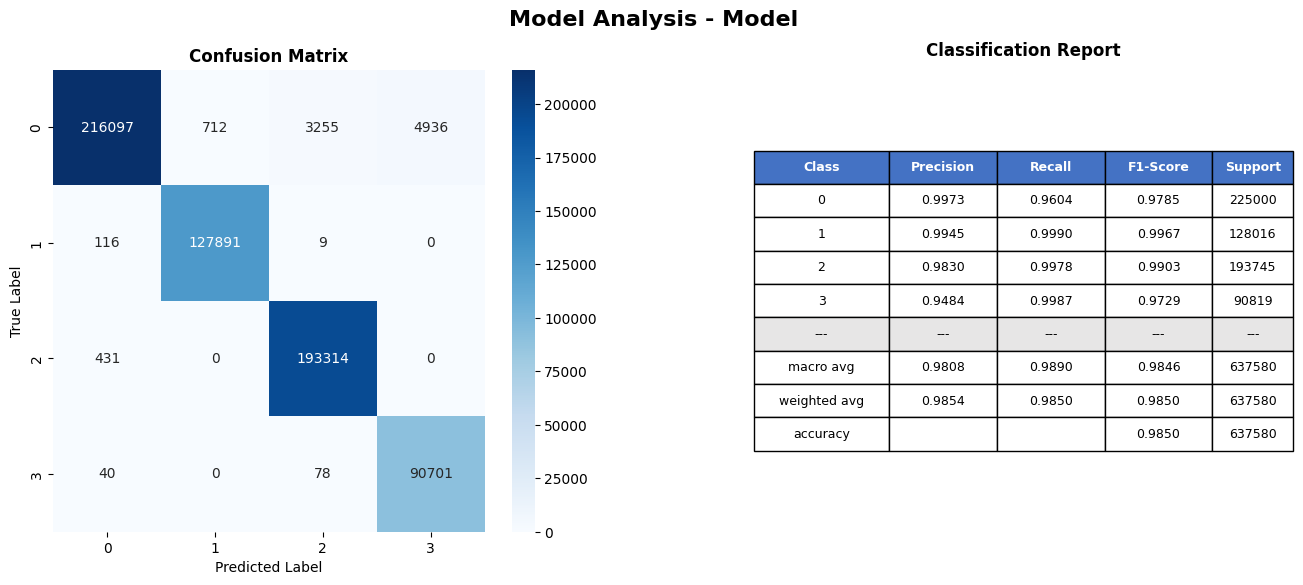

In [5]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)),
    y_test=torch.vstack((y_train, y_val)),
    logger=logger,
    save_fig=False,
    plot=True,
    device=device
)

In [6]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[0]

adversarial_attack_input = dataset.features.iloc[attack_indices[random_idx]].values.astype('float32')

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).clone().detach().requires_grad_(True)
adversarial_attack_input = adversarial_attack_input.unsqueeze(0).to(device)

print("Original input:", adversarial_attack_input)

Original input: tensor([[ 8.0000e+01,  1.0083e+07,  4.0000e+00,  0.0000e+00,  2.4000e+01,
          0.0000e+00,  6.0000e+00,  6.0000e+00,  6.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3803e+00,
          3.9672e-01,  3.3609e+06,  5.8204e+06,  1.0100e+07,  3.0000e+00,
          1.0100e+07,  3.3609e+06,  5.8204e+06,  1.0100e+07,  3.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  8.0000e+01,  0.0000e+00,  3.9672e-01,
          0.0000e+00,  6.0000e+00,  6.0000e+00,  6.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          7.5000e+00,  6.0000e+00,  0.0000e+00,  8.0000e+01,  4.0000e+00,
          2.4000e+01,  0.0000e+00,  0.0000e+00,  2.5600e+02, -1.0000e+00,
          3.0000e+00,  2.0000e+01,  1.0060e+03,  0.0000e+00,  1.0060e+03,
          1.0060e+03, 

In [7]:
x_adv = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([0]).to(device)  # Targeting the 'benign' class

model_mlp.eval()
epsilon = 1e-2

# Initial prediction
initial_x_adv, initial_loss, initial_pred = attack_fgsm(
    model=model_mlp,
    criterion=criterion,
    x_val=x_adv,
    target=target,
    eps=0.0
)

print("Initial prediction on adversarial input:", initial_pred, initial_pred.argmax())

for iter in range(100):
    x_adv, loss, pred = attack_fgsm(
        model=model_mlp,
        criterion=criterion,
        x_val=x_adv,
        target=target,
        eps=1e-2
    )

    if pred.argmax() == 0:
        break

print(f"Adversarial input after {iter+1} iterations:", pred, pred.argmax())

Initial prediction on adversarial input: [[ 3.8617287 13.844144  -6.869007  -9.544049 ]] 1
Adversarial input after 9 iterations: [[ 7.028026   6.674691  -6.4663157 -5.436081 ]] 0
